## Etapas do projeto:
1. Definição do Problema de Negócio e Objetivo do projeto
2. Coleta e preparação dos dados
3. Análise Exploratória de Dados
4. Pré-processamento de Dados
5. Modelagem e Avaliação do Modelo
6. Interpretação dos Resultados
7. Deploy do Modelo
8. Aplicação do Modelo

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

In [2]:
#Importando o arquivo csv
dataset = pd.read_excel('C:/Users/guipi/Desktop/tcc codigo/spotify-2023.xlsx', sheet_name='Sheet1', engine='openpyxl')
dataset.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951 entries, 0 to 950
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   track_name            951 non-null    object 
 1   artist(s)_name        951 non-null    object 
 2   artist_count          951 non-null    int64  
 3   released_year         951 non-null    int64  
 4   released_month        951 non-null    int64  
 5   released_day          951 non-null    int64  
 6   in_spotify_playlists  951 non-null    int64  
 7   in_spotify_charts     951 non-null    int64  
 8   streams               951 non-null    int64  
 9   in_apple_playlists    951 non-null    int64  
 10  in_apple_charts       951 non-null    int64  
 11  in_deezer_playlists   951 non-null    int64  
 12  in_deezer_charts      951 non-null    int64  
 13  in_shazam_charts      901 non-null    float64
 14  bpm                   951 non-null    int64  
 15  key                   8

In [4]:
missing = dataset.isnull().sum()
missing

track_name               0
artist(s)_name           0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
in_spotify_charts        0
streams                  0
in_apple_playlists       0
in_apple_charts          0
in_deezer_playlists      0
in_deezer_charts         0
in_shazam_charts        50
bpm                      0
key                     95
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
acousticness_%           0
instrumentalness_%       0
liveness_%               0
speechiness_%            0
dtype: int64

#### Lidando com os valores nulos:
- In_shazam_charts: 
Como essa variável representta um ranking nos charts do Shazam, valores nulos ou missing indicam que a música em específico não atingiram um rank.
A estratégia para lidar com essa coluna foi de substituir os valores vazios por um valor numérico, no caso, o rank máximo +1, garantindo que o modelo receba apenas valores puramente numéricos, sem perder a informação das músicas que não foram ranqueadas.

In [5]:
# Create another copy for ML processing
dataset['in_shazam_charts_ML'] = dataset['in_shazam_charts'].copy()
max_rank = dataset['in_shazam_charts_ML'].max()
dataset['in_shazam_charts_ML'].fillna(max_rank + 1, inplace=True)

# Drop the original 'in_shazam_charts' column
dataset.drop('in_shazam_charts', axis=1, inplace=True)

dataset['in_shazam_charts_ML'] = dataset['in_shazam_charts_ML'].astype(int)

- Key:
Essa variável representa o tom em que a música foi composta. Assumir valores como mediana ou média pode atrapalhar a análise, portanto nesse caso as linhas com valores nulos serão totalmente removidas, para evitar que a análise final seja impactada.

In [6]:
# Remove the rows with missing 'key' values
dataset = dataset.dropna(subset=['key'])

In [7]:
# Verificação e correção dos tipos de dados
print(dataset.dtypes)

track_name              object
artist(s)_name          object
artist_count             int64
released_year            int64
released_month           int64
released_day             int64
in_spotify_playlists     int64
in_spotify_charts        int64
streams                  int64
in_apple_playlists       int64
in_apple_charts          int64
in_deezer_playlists      int64
in_deezer_charts         int64
bpm                      int64
key                     object
mode                    object
danceability_%           int64
valence_%                int64
energy_%                 int64
acousticness_%           int64
instrumentalness_%       int64
liveness_%               int64
speechiness_%            int64
in_shazam_charts_ML      int32
dtype: object


In [8]:
# Combinando as colunas 'released_year', 'released_month', and 'released_day' em uma única coluna de data
dataset['release_date'] = pd.to_datetime(dataset['released_year'].astype(str) + '-' + 
                                      dataset['released_month'].astype(str) + '-' + 
                                      dataset['released_day'].astype(str), errors='coerce')
print(dataset['release_date'].head(10))

0   2023-07-14
1   2023-03-23
2   2023-06-30
3   2019-08-23
4   2023-05-18
5   2023-06-01
6   2023-03-16
7   2023-07-07
8   2023-05-15
9   2023-03-17
Name: release_date, dtype: datetime64[ns]


In [9]:
#Convertendo 'streams', 'in_deezer_playlists' para valores numéricos:
dataset['streams'] = pd.to_numeric(dataset['streams'], errors='coerce')
dataset['in_deezer_playlists'] = pd.to_numeric(dataset['in_deezer_playlists'], errors='coerce')

In [10]:
print(dataset.dtypes)

track_name                      object
artist(s)_name                  object
artist_count                     int64
released_year                    int64
released_month                   int64
released_day                     int64
in_spotify_playlists             int64
in_spotify_charts                int64
streams                          int64
in_apple_playlists               int64
in_apple_charts                  int64
in_deezer_playlists              int64
in_deezer_charts                 int64
bpm                              int64
key                             object
mode                            object
danceability_%                   int64
valence_%                        int64
energy_%                         int64
acousticness_%                   int64
instrumentalness_%               int64
liveness_%                       int64
speechiness_%                    int64
in_shazam_charts_ML              int32
release_date            datetime64[ns]
dtype: object


In [11]:
#One hot encoding
mode_encoded = pd.get_dummies(dataset['mode'], prefix='mode')
dataset = pd.concat([dataset, mode_encoded], axis=1)
label_encoder = LabelEncoder()
dataset['key_encoded'] = label_encoder.fit_transform(dataset['key'].astype(str))

print(dataset[['mode', *mode_encoded.columns, 'key', 'key_encoded']].head())

    mode  mode_Major  mode_Minor key  key_encoded
0  Major           1           0   B            2
1  Major           1           0  C#            3
2  Major           1           0   F            7
3  Major           1           0   A            0
4  Minor           0           1   A            0


In [12]:
dataset.dtypes

track_name                      object
artist(s)_name                  object
artist_count                     int64
released_year                    int64
released_month                   int64
released_day                     int64
in_spotify_playlists             int64
in_spotify_charts                int64
streams                          int64
in_apple_playlists               int64
in_apple_charts                  int64
in_deezer_playlists              int64
in_deezer_charts                 int64
bpm                              int64
key                             object
mode                            object
danceability_%                   int64
valence_%                        int64
energy_%                         int64
acousticness_%                   int64
instrumentalness_%               int64
liveness_%                       int64
speechiness_%                    int64
in_shazam_charts_ML              int32
release_date            datetime64[ns]
mode_Major               

In [13]:
#Definindo as colunas que estão em porcentagem
percentage_columns = ['danceability_%', 'valence_%', 'energy_%', 
    'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']
for col in percentage_columns:
    print(f"{col}: Min = {dataset[col].min()}, Max = {dataset[col].max()}")

danceability_%: Min = 23, Max = 96
valence_%: Min = 4, Max = 97
energy_%: Min = 14, Max = 97
acousticness_%: Min = 0, Max = 97
instrumentalness_%: Min = 0, Max = 91
liveness_%: Min = 3, Max = 97
speechiness_%: Min = 2, Max = 64


In [14]:
# Corrigindo a escala das colunas em porcentagem
for col in percentage_columns:
    dataset[col + '_ML'] = dataset[col] / 100.0

In [15]:
print(dataset.dtypes)

track_name                       object
artist(s)_name                   object
artist_count                      int64
released_year                     int64
released_month                    int64
released_day                      int64
in_spotify_playlists              int64
in_spotify_charts                 int64
streams                           int64
in_apple_playlists                int64
in_apple_charts                   int64
in_deezer_playlists               int64
in_deezer_charts                  int64
bpm                               int64
key                              object
mode                             object
danceability_%                    int64
valence_%                         int64
energy_%                          int64
acousticness_%                    int64
instrumentalness_%                int64
liveness_%                        int64
speechiness_%                     int64
in_shazam_charts_ML               int32
release_date             datetime64[ns]


### Data Visualization

In [16]:
descritiva = dataset.describe()
print(descritiva)

       artist_count  released_year  released_month  released_day  \
count    856.000000     856.000000      856.000000    856.000000   
mean       1.551402    2018.293224        6.024533     13.745327   
std        0.865004      10.996831        3.563375      9.291666   
min        1.000000    1930.000000        1.000000      1.000000   
25%        1.000000    2020.000000        3.000000      5.000000   
50%        1.000000    2022.000000        5.000000     13.000000   
75%        2.000000    2022.000000        9.000000     22.000000   
max        8.000000    2023.000000       12.000000     31.000000   

       in_spotify_playlists  in_spotify_charts       streams  \
count            856.000000         856.000000  8.560000e+02   
mean            5210.186916          11.942757  5.139551e+08   
std             7947.223670          19.199421  5.715497e+08   
min               31.000000           0.000000  1.365184e+06   
25%              862.750000           0.000000  1.395599e+08   
50%

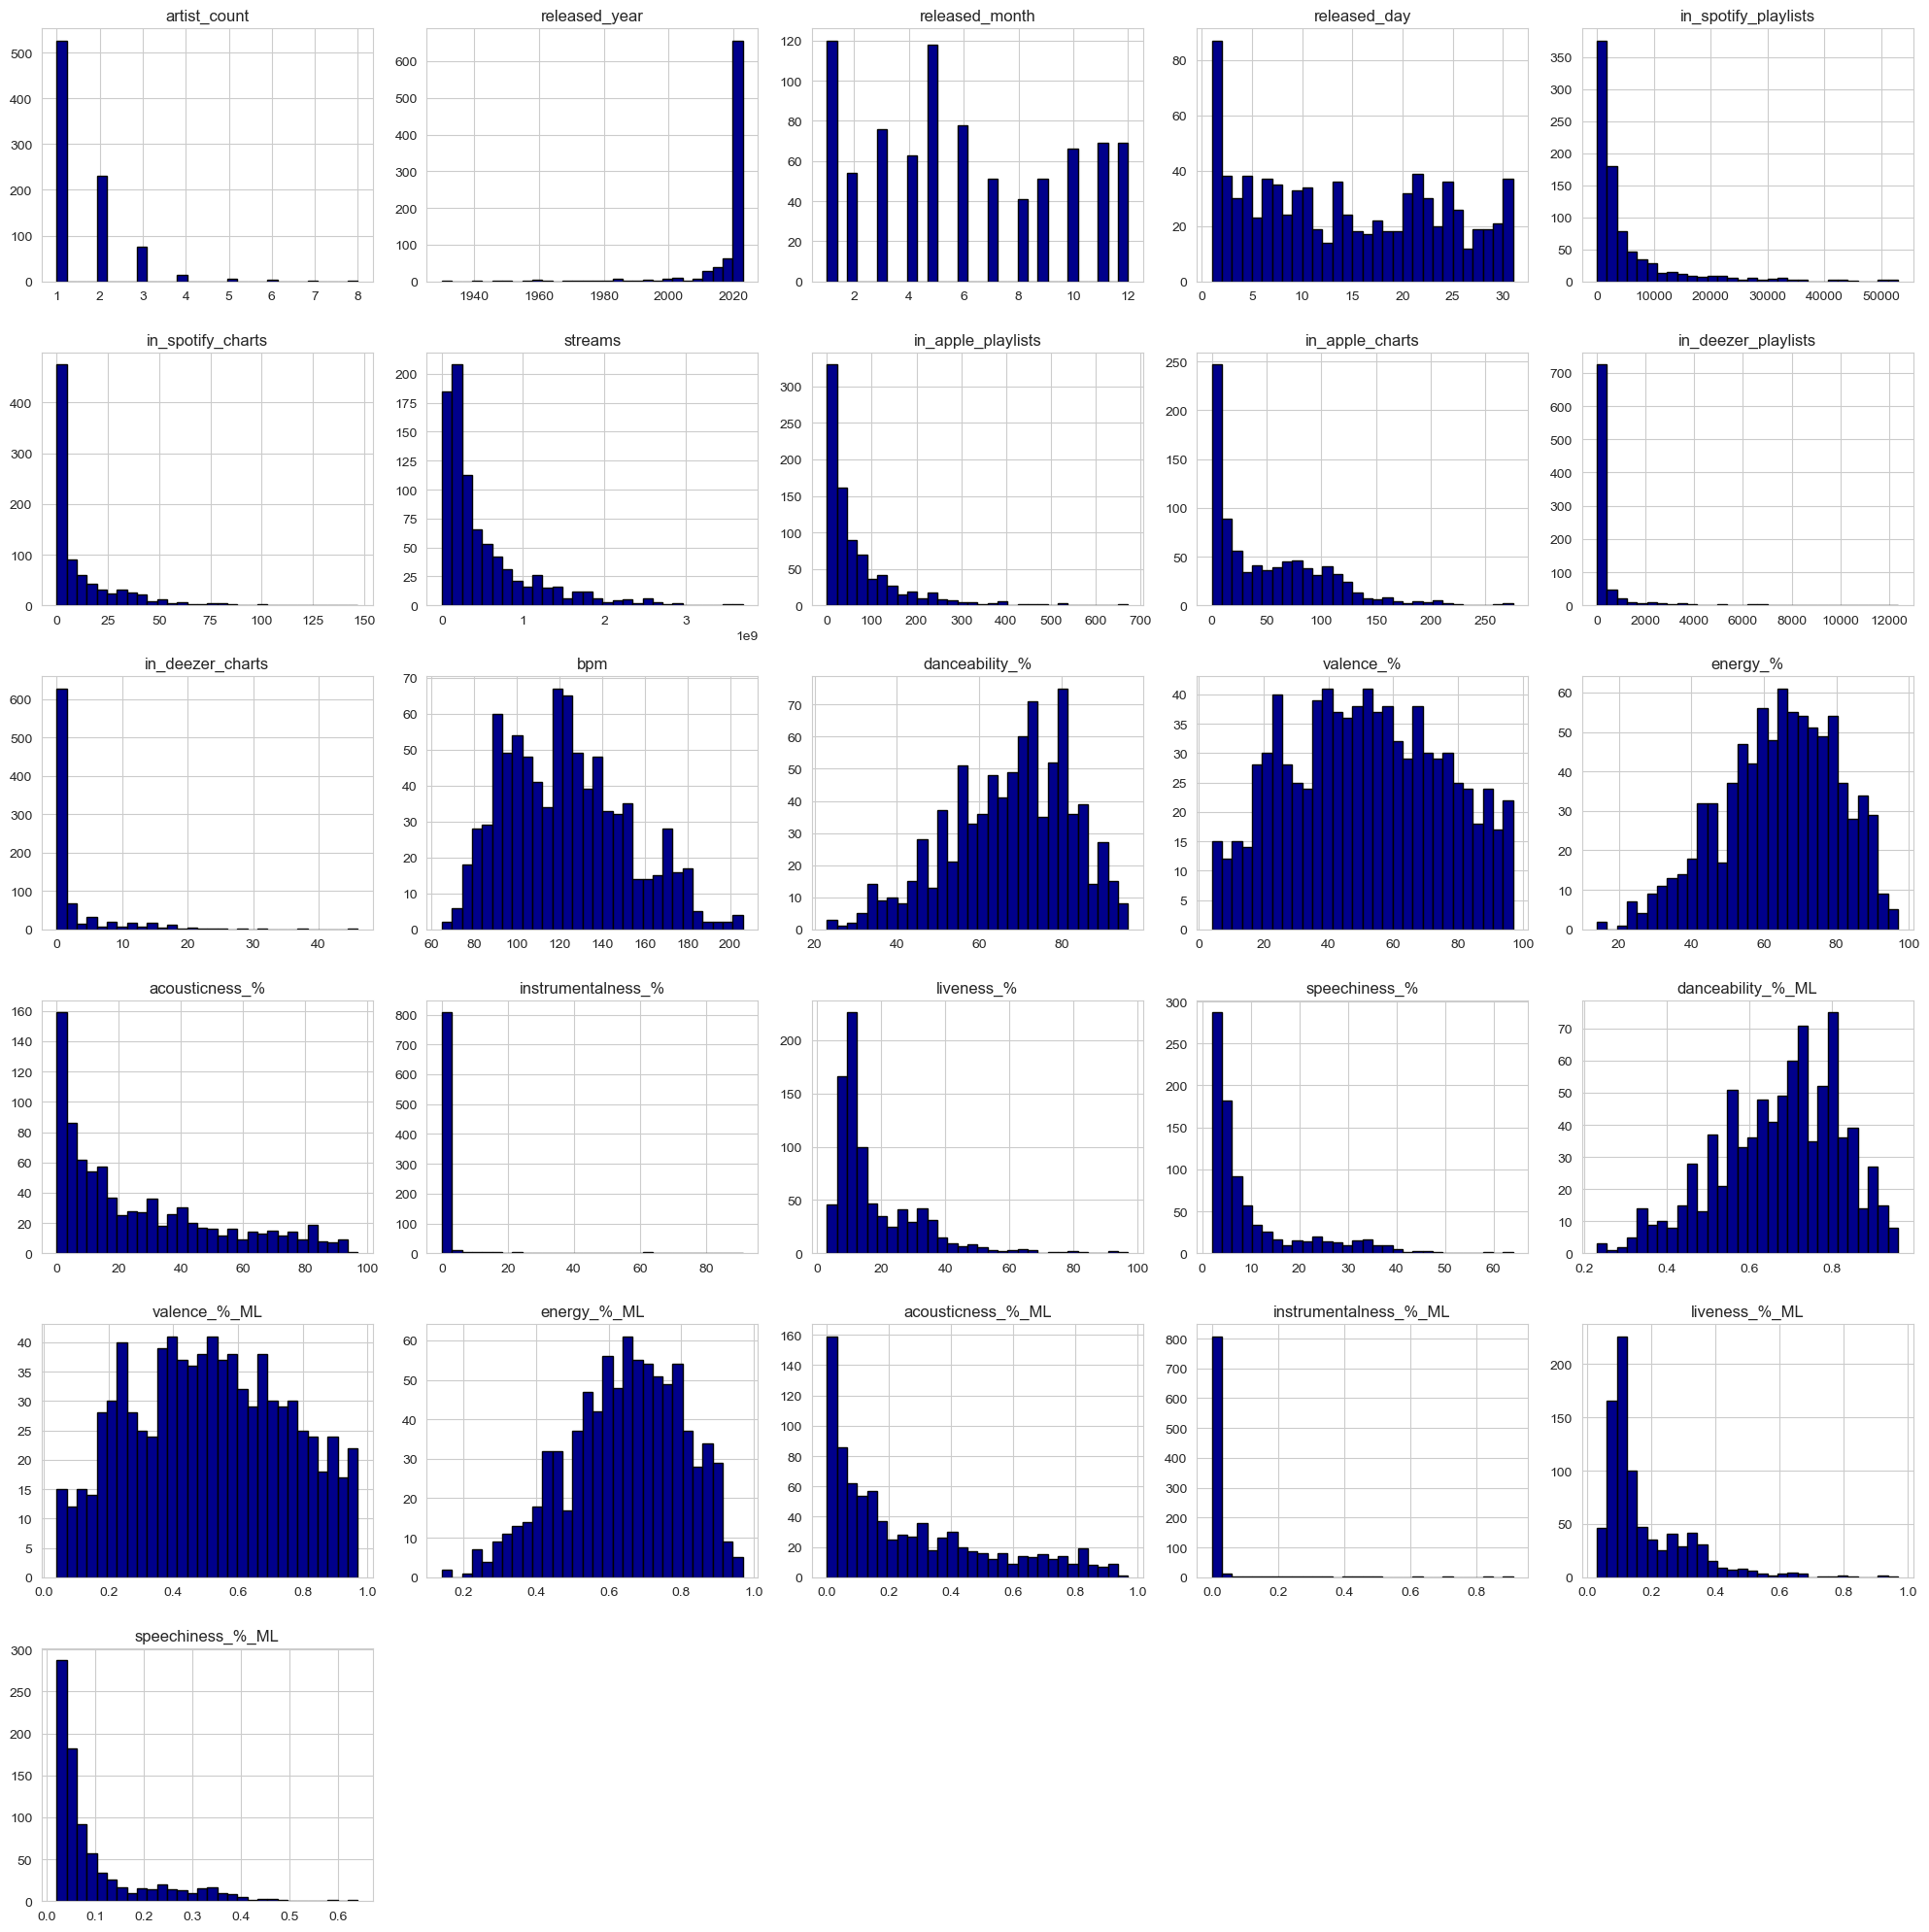

In [17]:
#Histogramas
sns.set_style('whitegrid')
dataset.select_dtypes(include=['float64', 'int64']).hist(bins=30, figsize=(20,20), color='darkblue', edgecolor='black')
plt.tight_layout()  
plt.show()

Com base nos histogramas, aqui estão algumas observações importantes:

artist_count: A maioria das músicas é tocada por um único artista, mas também há um número notável de músicas com vários artistas.

ano_de lançamento: a maior parte das músicas no conjunto de dados foi lançada depois de 1980, com um aumento muito acentuado no número de músicas lançadas depois de 2000. O pico parece ocorrer na década de 2020, sugerindo que a maioria dos dados pertence a músicas muito recentes.

mês_de lançamento: janeiro (1) e maio (5) parecem ser meses particularmente populares para lançamentos de músicas. Isto pode ser devido a vários motivos, como práticas da indústria ou tendências sazonais.

release_day: Há um ligeiro pico no início e no meio do mês, mas no geral, os lançamentos de músicas são relativamente distribuídos ao longo do mês.

Colunas in_playlists e in_charts: a maioria das músicas não está presente ou aparece apenas em algumas playlists ou paradas. No entanto, há um pequeno subconjunto de músicas que parecem dominar em termos de serem adicionadas a muitas playlists ou chegarem às paradas.

bpm (batidas por minuto): As músicas variam amplamente em bpm, mas há um pico proeminente em torno de 80-100 bpm, indicando que um andamento moderado é bastante popular.

Dançabilidade, Valência, Energia e outras métricas de %: Esses atributos exibem vários níveis de assimetria, mas a maioria deles, como dançabilidade e energia, mostram uma ampla distribuição indicando diversas propriedades musicais.

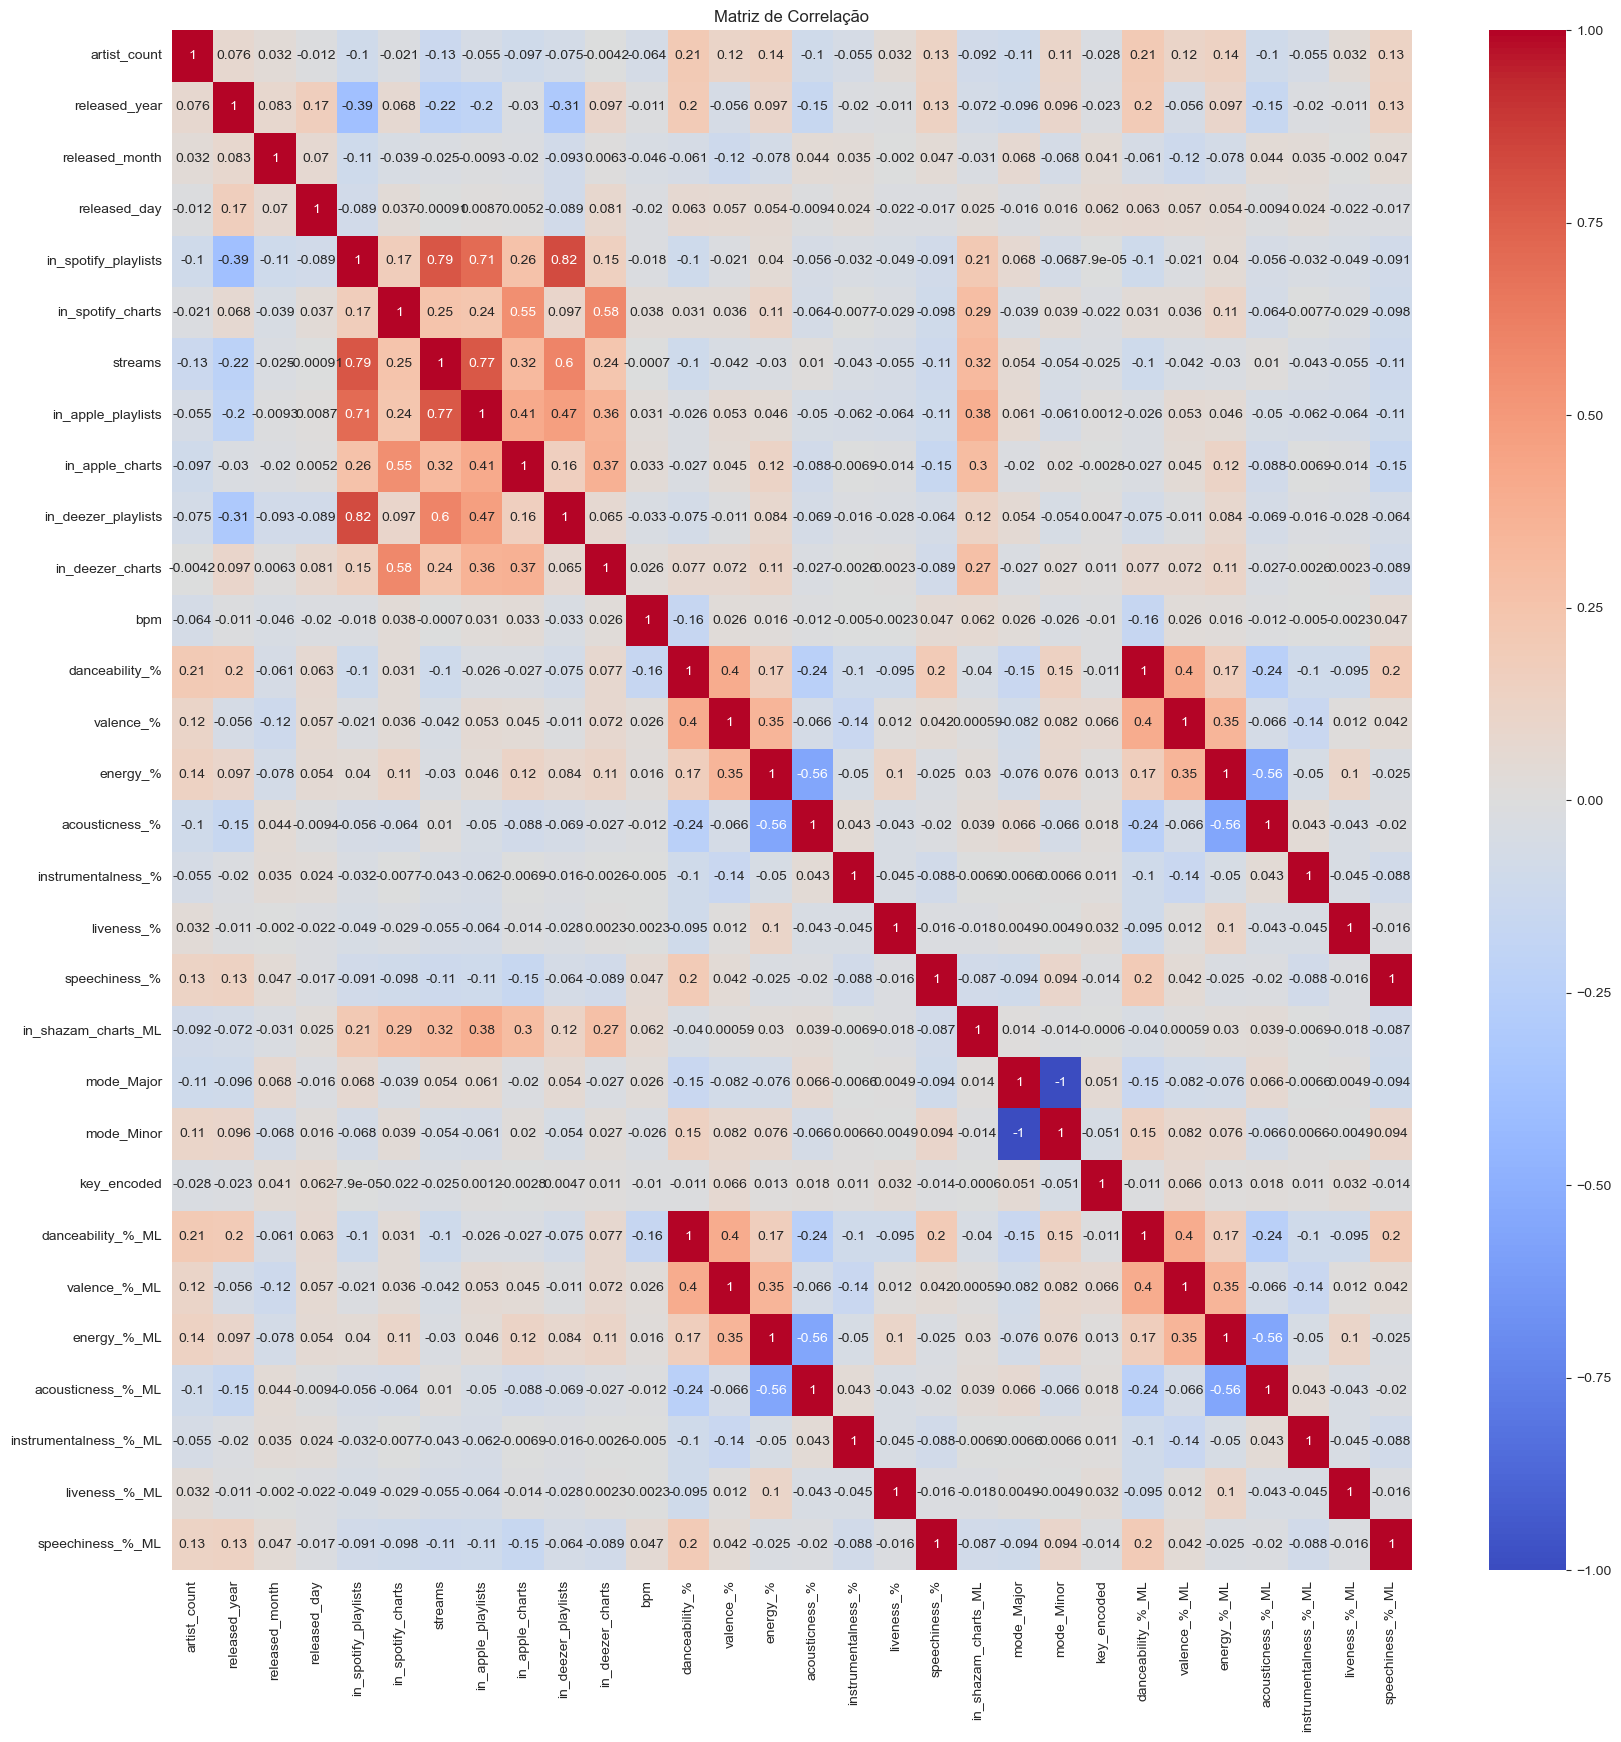

In [18]:
#Matriz de correlação

numericos = dataset.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numericos.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Matriz de Correlação")
plt.show()

Valores altamente correlacionados:

dançabilidade% e valência% estão positivamente correlacionados. Isso sugere que faixas com alta dançabilidade geralmente têm alta valência, o que significa que são tipicamente mais otimistas ou alegres.

% de energia e% de valência também mostram uma correlação positiva. Faixas com mais energia provavelmente serão mais positivas.

Consistência de plataformas de streaming:
A presença de uma música em playlists de diferentes plataformas (in_spotify_playlists, in_apple_playlists, in_deezer_playlists) está moderadamente correlacionada, indicando que faixas populares nas playlists de uma plataforma provavelmente aparecerão em outras.

Gráficos x listas de reprodução:
Estar nas paradas e nas playlists de cada plataforma (por exemplo, in_spotify_playlists vs. in_spotify_charts) tem correlações positivas, embora não extremamente altas. Isso sugere que, embora as músicas que chegam às paradas provavelmente estejam em playlists, isso não é uma garantia estrita.

Propriedades musicais:
bpm (batidas por minuto) não tem correlações fortes com a maioria dos outros recursos, o que implica que o andamento não é um fator significativo para a presença de uma música em playlists ou paradas.

### Modelagem

In [19]:
#Random Forest - Default Hyperparameters
#Colunas que serão utilizadas
cols_to_use = ['artist_count', 'released_year',
    'in_spotify_playlists', 'in_spotify_charts', 'in_apple_playlists', 'in_apple_charts', 
    'in_deezer_playlists', 'in_deezer_charts', 'bpm', 'danceability_%_ML', 
    'valence_%_ML', 'energy_%_ML', 'acousticness_%_ML', 'instrumentalness_%_ML', 
    'liveness_%_ML', 'speechiness_%_ML', 'key_encoded']

X = dataset[cols_to_use]
y = dataset['streams']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)

y_pred = rf_regressor.predict(X_test)

#Scores
print("R2 Score:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Mean Absolute Error", mean_absolute_error(y_test, y_pred))

R2 Score: 0.805865792489278
Mean Squared Error: 7.650290471907842e+16
Mean Absolute Error 164668714.80494162


In [20]:
# Verificando quais features tem maior importância no modelo
feature_importances = rf_regressor.feature_importances_
features_df = pd.DataFrame({'Feature': cols_to_use,'Importance': feature_importances})

print(features_df.sort_values(by='Importance', ascending=False))

                  Feature  Importance
6     in_deezer_playlists    0.505678
2    in_spotify_playlists    0.302086
1           released_year    0.043064
4      in_apple_playlists    0.029698
3       in_spotify_charts    0.020526
5         in_apple_charts    0.015115
8                     bpm    0.012166
11            energy_%_ML    0.011574
14          liveness_%_ML    0.011398
12      acousticness_%_ML    0.009543
9       danceability_%_ML    0.008542
10           valence_%_ML    0.007681
15       speechiness_%_ML    0.007410
16            key_encoded    0.005522
7        in_deezer_charts    0.005179
0            artist_count    0.002914
13  instrumentalness_%_ML    0.001904


In [21]:
#Using the best hyperparameters - Via gridsearch

param_grid = {'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto']}

rf_model = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_rf_model = RandomForestRegressor(**best_params)
best_rf_model.fit(X_train, y_train)

#Previsão
y_pred = best_rf_model.predict(X_test)

#Scores
print("R2 Score:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Mean Absolute Error", mean_absolute_error(y_test, y_pred))

R2 Score: 0.8098204863546694
Mean Squared Error: 7.494446959393203e+16
Mean Absolute Error 164617819.79507098


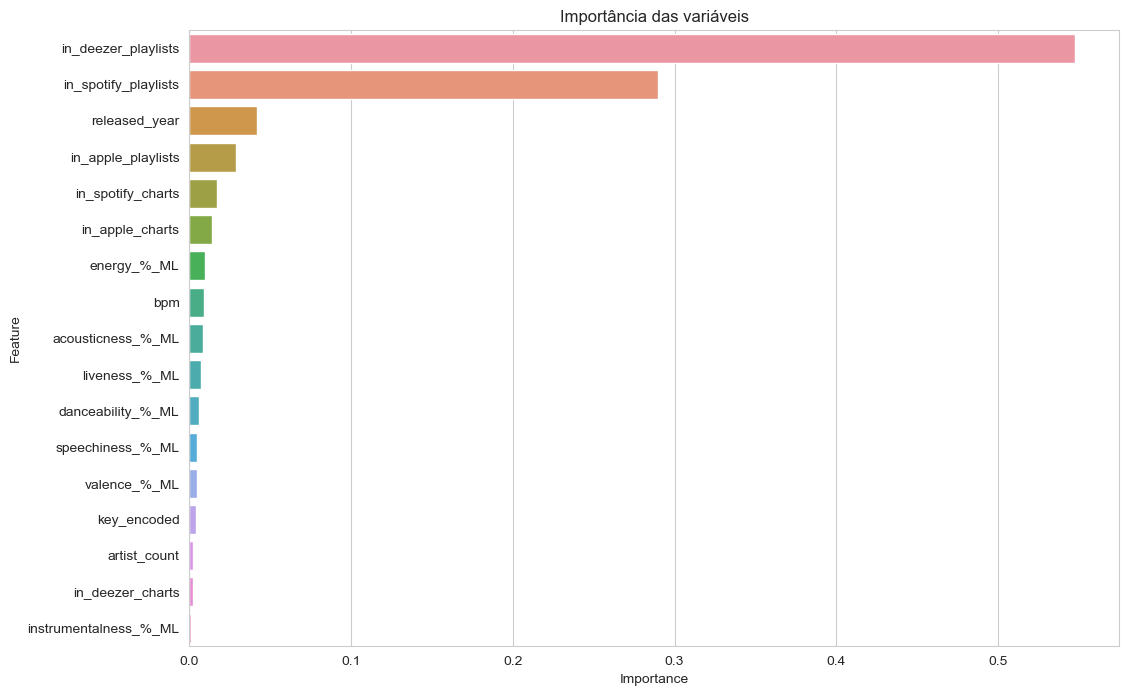

In [22]:
# Extract feature importances from the trained Random Forest model
importances = grid_search.best_estimator_.feature_importances_
features = cols_to_use

# Create a DataFrame for the importances and plot
df_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
df_importances = df_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=df_importances)
plt.title('Importância das variáveis')
plt.show()

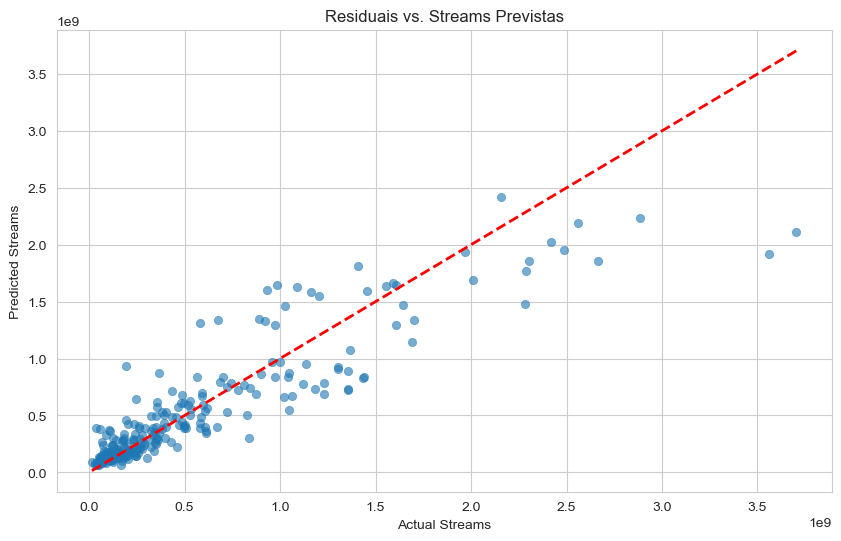

In [23]:
# Actual vs. Predicted Streams
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, edgecolor=None)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2)
plt.xlabel('Actual Streams')
plt.ylabel('Predicted Streams')
plt.title('Residuais vs. Streams Previstas')
plt.show()

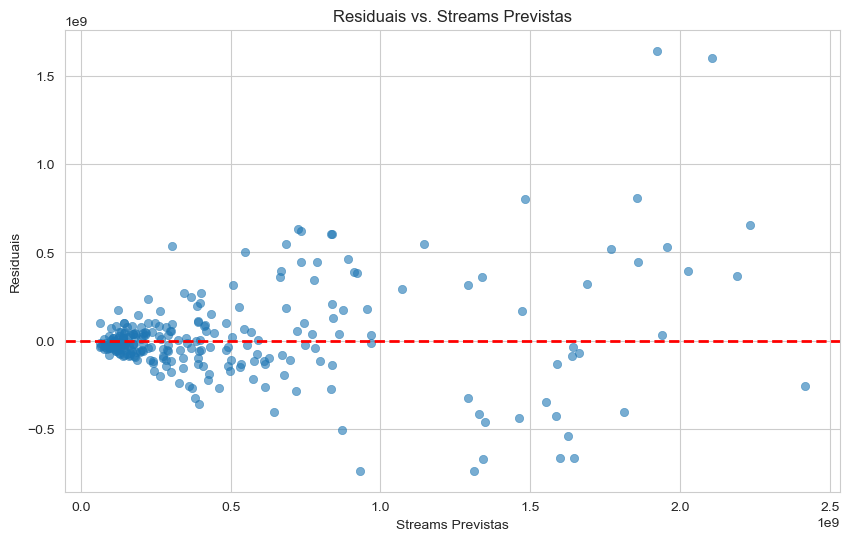

In [24]:
# Plot the residuals against predicted streams to assess model accuracy.
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, edgecolor=None)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel('Streams Previstas')
plt.ylabel('Residuais')
plt.title('Residuais vs. Streams Previstas')
plt.show()

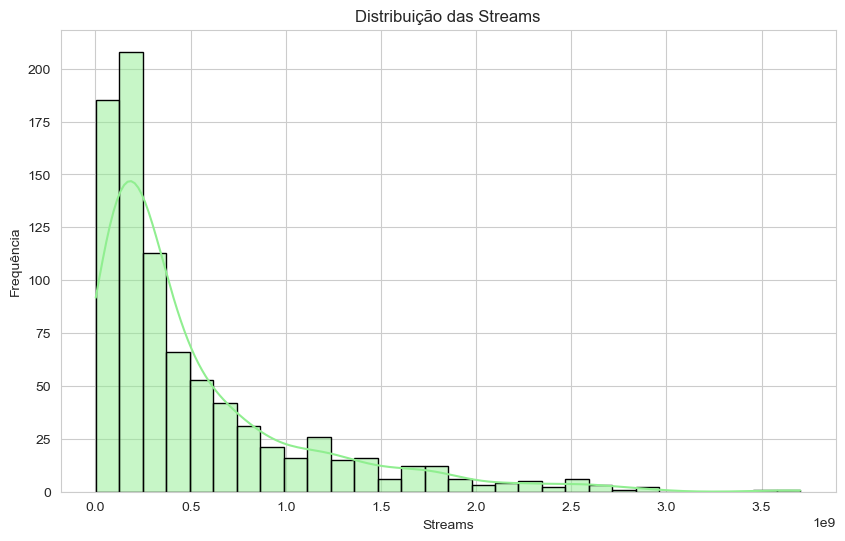

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(dataset['streams'], kde=True, color='lightgreen', edgecolor='black', bins=30)
plt.title('Distribuição das Streams')
plt.xlabel('Streams')
plt.ylabel('Frequência')
plt.show()